In [1]:
#Import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import IPython
import sklearn #Machine Learning package
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Dataset

df = pd.read_csv ('Peak_matching_Campylobacter.csv') #Import the peak matching table as a dataframe
Y = df['AMR'] # Target variable will be the AMR pattern (what you want to predict)
X = df.drop(columns=['AMR','ID']) #MALDI peaks and their intensities are feature set (The AMR and ID columns are discarded)
saved_cols = X.columns #store columns names in this variable

df

,ID,AMR,Maldi:2101.13,Maldi:2133.00,Maldi:2140.33,Maldi:2171.61,Maldi:2178.87,Maldi:2186.48,Maldi:2204.42,Maldi:2219.94,...,Maldi:8271.93,Maldi:8460.76,Maldi:8544.43,Maldi:8680.23,Maldi:9155.54,Maldi:9551.62,Maldi:9688.51,Maldi:10096.58,Maldi:10276.02,Maldi:10323.79
0,C001,CipTet,6149.48,0.0,0.00,0,0.00,0,10760.85,0.0,...,0.00,1423.91,0.0,0,0.00,0.0,0.0,0.0,0.0,0.00
1,C002,CipTetAmp,6441.01,0.0,0.00,0,0.00,0,7774.66,0.0,...,1243.03,1441.91,0.0,0,0.00,0.0,0.0,0.0,0.0,0.00
2,C003,CipTetAmp,6305.78,0.0,5702.90,0,0.00,0,6823.47,0.0,...,1309.31,1874.15,0.0,0,502.94,0.0,0.0,0.0,0.0,0.00
3,C004,CipAmp,8278.14,0.0,0.00,0,0.00,0,8360.54,0.0,...,2433.00,1298.04,0.0,0,0.00,0.0,0.0,0.0,0.0,0.00
4,C005,CipTetAmp,4516.29,0.0,3238.39,0,0.00,0,5561.39,0.0,...,854.21,1064.58,0.0,0,0.00,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,CampyTof55$coli,Strep,0.00,0.0,0.00,0,1725.73,0,0.00,0.0,...,0.00,0.00,0.0,0,0.00,0.0,0.0,0.0,0.0,1010.08
336,CampyTof6$coli,CipEryTetGentAmpStrepKana,0.00,0.0,0.00,0,3296.41,0,0.00,0.0,...,0.00,0.00,0.0,0,0.00,0.0,0.0,0.0,0.0,1113.70
337,CampyTof7$coli,CipEryTetAmpKana,0.00,0.0,0.00,0,2067.44,0,0.00,0.0,...,0.00,0.00,0.0,0,0.00,0.0,0.0,0.0,0.0,552.07
338,CampyTof8$coli,CipEryTetAmp,0.00,0.0,0.00,0,2185.02,0,3580.36,0.0,...,0.00,0.00,0.0,0,0.00,0.0,0.0,0.0,0.0,732.86


In [3]:
#Features transformation/Scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #Store the function in the scaler variable
scaled = scaler.fit_transform(X) #transformed values into the (0,1) range

scaled_df = pd.DataFrame(scaled, Y, columns = saved_cols) #Create a new dataframe with the scaled intensities
scaled_df = scaled_df.reset_index() 

scaled_df.loc[scaled_df['AMR'].str.contains('Cip'), 'AMR'] = '1' # it will transform all label containing the string "Cip" into 1 (1 = resistant)
scaled_df.loc[~scaled_df['AMR'].str.contains('1'), 'AMR'] = '0' # it will transform all label NOT containing the string "1" into 0 (0 = susceptible)

scaled_df

,AMR,Maldi:2101.13,Maldi:2133.00,Maldi:2140.33,Maldi:2171.61,Maldi:2178.87,Maldi:2186.48,Maldi:2204.42,Maldi:2219.94,Maldi:2241.84,...,Maldi:8271.93,Maldi:8460.76,Maldi:8544.43,Maldi:8680.23,Maldi:9155.54,Maldi:9551.62,Maldi:9688.51,Maldi:10096.58,Maldi:10276.02,Maldi:10323.79
0,1,0.331507,0.0,0.00000,0.0,0.000000,0.0,0.315168,0.0,0.706413,...,0.000000,0.170114,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,1,0.347223,0.0,0.00000,0.0,0.000000,0.0,0.227707,0.0,0.716527,...,0.284416,0.172264,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,1,0.339933,0.0,1.00000,0.0,0.000000,0.0,0.199848,0.0,0.413765,...,0.299581,0.223904,0.0,0.0,0.526374,0.0,0.0,0.0,0.0,0.000000
3,1,0.446259,0.0,0.00000,0.0,0.000000,0.0,0.244867,0.0,0.748218,...,0.556691,0.155076,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,1,0.243465,0.0,0.56785,0.0,0.000000,0.0,0.162884,0.0,0.455512,...,0.195450,0.127185,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0,0.000000,0.0,0.00000,0.0,0.389472,0.0,0.000000,0.0,0.277401,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.277187
336,1,0.000000,0.0,0.00000,0.0,0.743951,0.0,0.000000,0.0,0.315389,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.305622
337,1,0.000000,0.0,0.00000,0.0,0.466591,0.0,0.000000,0.0,0.267447,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.151499
338,1,0.000000,0.0,0.00000,0.0,0.493127,0.0,0.104863,0.0,0.269763,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.201112


In [4]:
Y = scaled_df['AMR'].astype(float) # Need to convert categorical to numerical type value
X = scaled_df.drop(columns=['AMR']) 

print(scaled_df.groupby('AMR').size()) # A total of 183 CipR and 157 susceptible strains

AMR
0    157
1    183
dtype: int64


In [6]:
#Features selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=10, n_estimators=300) 
clf = clf.fit(X, Y)

model = SelectFromModel(clf, prefit=True)
X_new  = model.transform(X)

print("Before Feature selection",X.shape) # Before and After the features selection
print("After Feature selection",X_new.shape)

scaled_features_df = pd.DataFrame(X_new, Y) #Create a new dataframe with the scaled intensities

features = X.columns.values
print(features[model.get_support()]) # Features of interest retained for the model

Before Feature selection (340, 91)
After Feature selection (340, 35)
['Maldi:2178.87' 'Maldi:2204.42' 'Maldi:2241.84' 'Maldi:2620.64'
 'Maldi:2713.95' 'Maldi:2746.95' 'Maldi:2766.98' 'Maldi:2838.35'
 'Maldi:3215.99' 'Maldi:3257.41' 'Maldi:3272.71' 'Maldi:3517.13'
 'Maldi:3531.87' 'Maldi:3540.98' 'Maldi:4159.99' 'Maldi:4230.48'
 'Maldi:4365.25' 'Maldi:4776.92' 'Maldi:5139.47' 'Maldi:5163.39'
 'Maldi:5183.58' 'Maldi:5246.59' 'Maldi:5498.73' 'Maldi:5867.81'
 'Maldi:6158.46' 'Maldi:6436.22' 'Maldi:7036.17' 'Maldi:7083.30'
 'Maldi:8153.75' 'Maldi:8257.58' 'Maldi:8271.93' 'Maldi:8460.76'
 'Maldi:9551.62' 'Maldi:10276.02' 'Maldi:10323.79']


In [ ]:
#Training/Validation/Test set



In [14]:
#Training/Validation/Test set

from sklearn.model_selection import train_test_split

X_train, X_rem, Y_train, Y_rem = train_test_split(X_new, Y, test_size=0.3,stratify=Y,random_state=0, shuffle=True) # Split the dataset into a 70/30 training/test set based on the AMR label

X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


(238, 35)
(51, 35)
(51, 35)


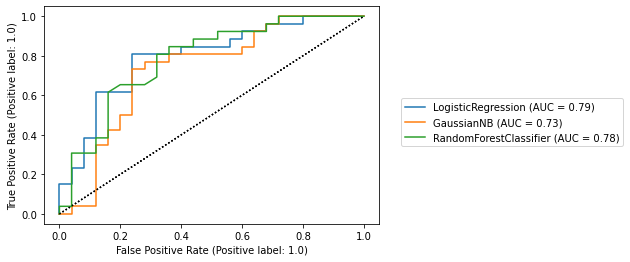

In [16]:
#Model selection

from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#Fitting different models to the training data

LR = LogisticRegression().fit(X_train, Y_train) 
NB = GaussianNB().fit (X_train, Y_train)
RF = RandomForestClassifier().fit(X_train,Y_train)

#ROC Curve

classifiers = [LR, NB, RF]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_valid, Y_valid, ax=ax)
    plt.plot([0,1], [0,1], ':',linewidth=1.4, c='k')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    

AUPRC 0.8501678229087241
AUPRC 0.9176417885186926
AUPRC 0.8305492704562566


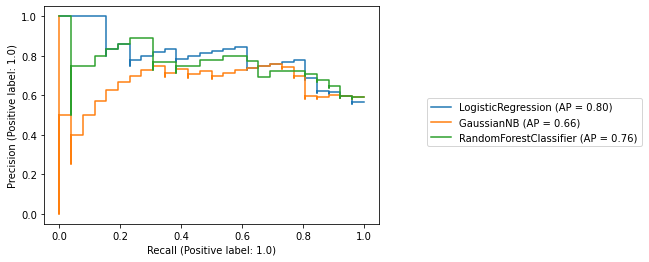

In [17]:
#Precision-Recall curve

classifiers1 = [LR, NB, RF]
ax = plt.gca()
for i in classifiers1 :
    plot_precision_recall_curve(i, X_valid, Y_valid, ax=ax)
    plt.legend(bbox_to_anchor = (1.8, 0.6))
    
for z in classifiers1 :
    precision, recall, thresholds = precision_recall_curve(Y_test, z.predict_proba(X_test)[:,1])
    area = auc(recall, precision)
    print("AUPRC",area)    


In [18]:
#Tune the model: Grid Search

from sklearn.model_selection import GridSearchCV

# Design the grid of parameters you want to investigate

param_grid = {
'max_depth': [80, 90, 100, 110],
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [100, 200, 300, 1000]
}

RF = RandomForestClassifier()
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, cv= 10, n_jobs = -1, verbose = 2, scoring='f1') # Best parameters for the Random Forest model based on the F1 score
grid_search.fit(X_valid, Y_valid)
grid_search.best_estimator_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


RandomForestClassifier(max_depth=110, max_features=2, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=200)

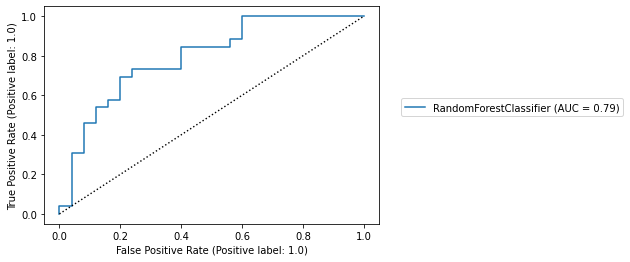

In [19]:
#Performance

RF = RandomForestClassifier(max_depth=110, max_features=2, min_samples_leaf=3,min_samples_split=8, n_estimators=200).fit (X_train, Y_train) # Fit the model with the optimized hyperparameters

#ROC Curve

classifiers = [RF]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_valid, Y_valid, ax=ax)
    plt.plot([0,1], [0,1], ':',linewidth=1.4, c='k')
    plt.legend(bbox_to_anchor = (1.05, 0.6))

AUPRC 0.8100280452161871


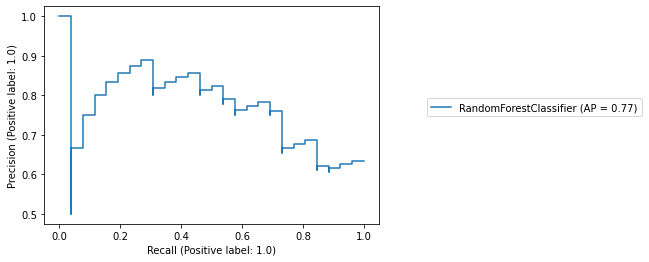

In [20]:
#Precision-Recall curve

classifiers1 = [RF]
ax = plt.gca()
for i in classifiers1 :
    plot_precision_recall_curve(i, X_valid, Y_valid, ax=ax)
    plt.legend(bbox_to_anchor = (1.8, 0.6))
    
# Compute Precision-Recall and plot curve

precision, recall, thresholds = precision_recall_curve(Y_test, RF.predict_proba(X_test)[:,1])
area = auc(recall, precision)

print("AUPRC",area)

F1-score: 0.7586206896551724
Precision: 0.6875
Recall: 0.8461538461538461
Accuracy :  0.7254901960784313
Specificity :  0.6
Sensitivity :  0.8461538461538461


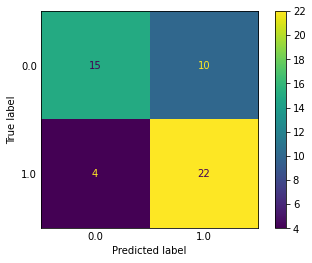

In [21]:
#Optimization of the Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#Metrics

y_pred_rf=RF.predict(X_valid)
confusion = confusion_matrix(Y_valid,y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=RF.classes_).plot()
plt.tick_params(axis=u'both', which=u'both',length=0)

precision= precision_score(Y_valid, y_pred_rf)
recall=recall_score(Y_valid, y_pred_rf)
F1= f1_score(Y_valid, y_pred_rf)
print('F1-score:',F1)
print('Precision:',precision)
print('Recall:',recall)

total1=sum(sum(confusion))
accuracy1=(confusion[0,0]+confusion[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = confusion[0,0]/(confusion[0,0]+confusion[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print('Sensitivity : ', sensitivity1)

Best Threshold=0.337941, F-Score=0.776


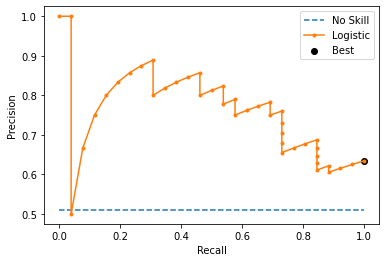

In [27]:
#Tune the model: Best threshold

from numpy import arange
from numpy import argmax
from matplotlib import pyplot
from numpy import sqrt

# predict probabilities
yhat = RF.predict_proba(X_valid)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(Y_valid, yhat)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(Y_valid[Y_valid==1]) / len(Y_valid)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

F1-score: 0.7761194029850745
Precision/PPV: 0.6341463414634146
Recall: 1.0
Accuracy :  0.7058823529411765
Specificity :  0.4
Sensitivity :  1.0
NPV:  1.0


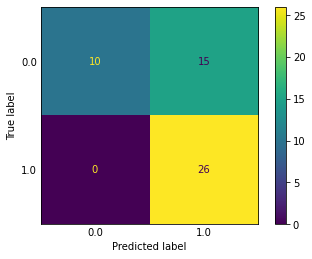

In [28]:
#Set the new threshold

y_pred_new_threshold = (RF.predict_proba(X_valid)[:,1]>=0.337941).astype(int)

#Metrics

confusion = confusion_matrix(Y_valid,y_pred_new_threshold )
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=RF.classes_).plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
precision= precision_score(Y_valid, y_pred_new_threshold)
recall=recall_score(Y_valid, y_pred_new_threshold)
F1= f1_score(Y_valid, y_pred_new_threshold)
print('F1-score:',F1)
print('Precision/PPV:',precision)
print('Recall:',recall)


total1=sum(sum(confusion))
accuracy1=(confusion[0,0]+confusion[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = confusion[0,0]/(confusion[0,0]+confusion[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print('Sensitivity : ', sensitivity1)
NPV = confusion[0,0]/(confusion[0,0]+confusion[1,0])
print('NPV: ', NPV)

F1-score: 0.8115942028985508
Precision/PPV: 0.7
Recall: 0.9655172413793104
Accuracy :  0.7450980392156863
Specificity :  0.45454545454545453
Sensitivity :  0.9655172413793104
NPV:  0.9090909090909091


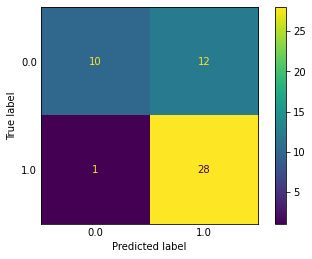

In [25]:
#Evaluation of the tuned model on the test set

y_pred_new_threshold = (RF.predict_proba(X_test)[:,1]>=0.337941).astype(int)

#Metrics

confusion = confusion_matrix(Y_test,y_pred_new_threshold )
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=RF.classes_).plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
precision= precision_score(Y_test, y_pred_new_threshold)
recall=recall_score(Y_test, y_pred_new_threshold)
F1= f1_score(Y_test, y_pred_new_threshold)
print('F1-score:',F1)
print('Precision/PPV:',precision)
print('Recall:',recall)


total1=sum(sum(confusion))
accuracy1=(confusion[0,0]+confusion[1,1])/total1
print ('Accuracy : ', accuracy1)
specificity1 = confusion[0,0]/(confusion[0,0]+confusion[0,1])
print('Specificity : ', specificity1 )
sensitivity1 = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print('Sensitivity : ', sensitivity1)
NPV = confusion[0,0]/(confusion[0,0]+confusion[1,0])
print('NPV: ', NPV)



In [ ]:
#Prediction

Unknown = pd.read_csv ('List_of_Unknow_Spectra.csv') # import the unknow spectra you want classify (they need to have the same features than the one used for the training)
prediction = (RF.predict_proba(Unknown)[:,1]>=0.359180).astype(int) #Will predict the class (0 or 1)

print("Prediction",prediction)